ControlNet
=====

**Adding Conditional Control to Text-to-Image Diffusion Models**

 * Paper: https://arxiv.org/pdf/2302.05543

![ControlNet Overview](../assets/controlnet_overview.png)

![ControlNet Overview](../assets/controlnet_arch.png)

```bash
git clone https://github.com/lllyasviel/ControlNet.git ControlNet_repo

sed -i 's,name: control$,name: controlnet,g' ControlNet_repo/environment.yaml

# upgrade transformers to be able to download 'openai/clip-vit-large-patch14'
pip install --upgrade transformers
```

 * Download the model using huggingface hub

```python
import shutil
from huggingface_hub import hf_hub_download
import os

repo_id = "lllyasviel/ControlNet"
filenames = [
    "models/control_sd15_canny.pth",
    "models/control_sd15_depth.pth",
    "models/control_sd15_seg.pth"
]

save_dir = "./models"

os.makedirs(save_dir, exist_ok=True)

for filename in filenames:
    cached_path = hf_hub_download(repo_id=repo_id, filename=filename)
    
    # Copy to your custom directory
    dst_path = os.path.join(save_dir, os.path.basename(filename))
    shutil.copyfile(cached_path, dst_path)
    print(f"Copied to: {dst_path}")

```

In [ ]:
import sys
sys.path.append("ControlNet_repo")

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random
from pytorch_lightning import seed_everything

from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

from share import *
import config


/home/pyml/anaconda3/envs/controlnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model('ControlNet_repo/models/cldm_v15.yaml').cpu()
#model.load_state_dict(load_state_dict('./models/control_sd15_canny.pth', location='cuda'))
state_dict = load_state_dict('./models/control_sd15_canny.pth', location=device)
missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")
model = model.to(device)
ddim_sampler = DDIMSampler(model)

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [ControlNet_repo/models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]
Missing keys: []
Unexpected keys: ['cond_stage_model.transformer.text_model.embeddings.position_ids']


In [7]:
def process(
        input_image,
        edge_map,
        prompt,
        a_prompt,
        n_prompt,
        num_samples=1,
        image_resolution=512,
        ddim_steps=20,
        guess_mode=False,
        strength=1.0,
        scale=9.0,
        seed=1,
        eta=0.0
    ):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        edge_map = resize_image(HWC3(edge_map), image_resolution)
        edge_map = HWC3(edge_map)

        control = torch.from_numpy(edge_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(
            ddim_steps, num_samples,
            shape, cond, verbose=False, eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (
            einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5
        ).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [255 - edge_map] + results

In [13]:
image_path = "../samples/plants.jpg"
input_image = cv2.imread(image_path)

# generate edge map using Canny edge detector
detector = CannyDetector()
detected_map = detector(input_image, low_threshold=100, high_threshold=200)

res = process(
    input_image=input_image,
    edge_map=detected_map,
    prompt="A photo of a plant",
    a_prompt="Aesthetic",
    n_prompt="Blurry",
    num_samples=1,
    image_resolution=512,
    ddim_steps=20,
    guess_mode=False,
    strength=1.0,
    scale=9.0,
    seed=1,
    eta=0.0
)

print(len(res))

Global seed set to 1


Data shape for DDIM sampling is (1, 4, 72, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]

2


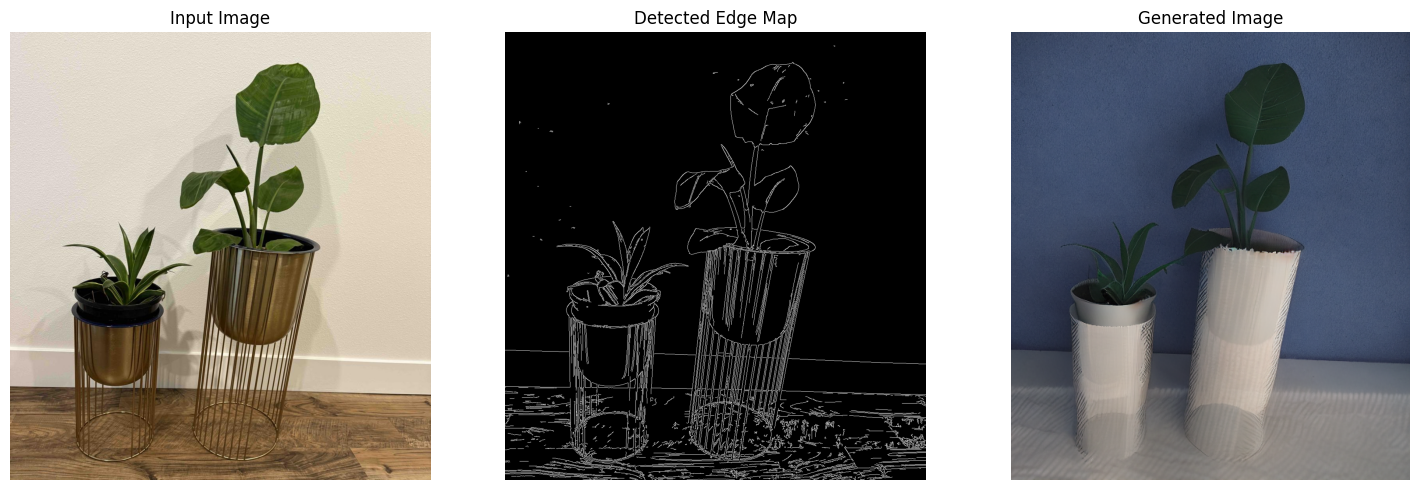

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Input Image")
axes[0].axis("off")
axes[1].imshow(cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB))
axes[1].set_title("Detected Edge Map")
axes[1].axis("off")
axes[2].imshow(cv2.cvtColor(res[1], cv2.COLOR_BGR2RGB))
axes[2].set_title("Generated Image")
axes[2].axis("off")
plt.tight_layout()
plt.show()